# DECISION FUSION IN TIME

IN: clinical data + RX t0
DECISION:   C1 = p1_1      C2 = p2_1
p1 or p2 are enough to decide? (choose parameter to be enough)

YES = DECISION TAKEN

NO = new image
IN 2: clinical data + RX t1
DECISION:   C1 = p1_2      C2 = p2_2

p1_2 or p2_2 compared to p1_1 and p2_1 are enough?

YES = DECISION TAKEN

NO = REPEAT UNTIL THERE ARE IMAGES


POSSIBILITY 2:

IN: clinical data   -> C1 = p1_c        C2 = p2_c


IN: RX_t0           -> C1 = p1_rx_t0    C2 = p2_rx_t0


DECISION = Combine [p1_c,p2_c,p1_rx_t0,p2_rx_t0]  and obtain pC1,pC2

if pC1,pC2 is not enough to make a decision: 

IN: RX_t1           -> C1 = p1_rx_t1    C2 = p2_rx_t1


DECISION = Combine [p1_c,p2_c,p1_rx_t1,p2_rx_t1]  and obtain pC1,pC2            or Combine as [p1_c,p2_c,p1_rx_t0,p2_rx_t0,p1_rx_t1,p2_rx_t1]   with all precedent times

if pC1,pC2 is not enough to make a decision: REPEAT UNTIL there are images

## IMPORT ALL

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import gc
import copy
import cv2

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm

import sklearn as sk
import tensorflow as tf
# import tensorflow.keras as keras
from tensorflow import keras
from pathlib import Path
import plotly.graph_objects as go
import keras.backend as K

import imblearn
from imblearn.over_sampling import RandomOverSampler

In [2]:
print(f"Python Version: {sys.version}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Imbalanced Learn Version: {imblearn.__version__}")

Python Version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Pandas Version: 1.3.5
Numpy Version: 1.22.3
Keras Version: 2.10.0
Imbalanced Learn Version: 0.9.1


In [3]:
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow_addons as tfa

c:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## FUNCTIONS

In [5]:
sys.path.append('./')
import Covid19_NY_Data_Loader_functions as load_fn
import Covid19_NY_Clinical_Data_Functions as clinical_fn
import Covid19_NY_CNN_Functions as cnn_fn

## Paths

In [6]:
BASEPT = Path('../Temporal-Decision-Fusion/')
BASEPT.mkdir(parents=True, exist_ok=True)
SaveTrainGraphPath = Path('../Temporal-Decision-Fusion/Report/Graphs')
SaveTrainGraphPath.mkdir(parents=True, exist_ok=True)
SaveTrainModelsPath = Path('../Temporal-Decision-Fusion/Report/Models')
SaveTrainModelsPath.mkdir(parents=True, exist_ok=True)
SaveTrainTablesPath = Path('../Temporal-Decision-Fusion/Report/tables')
SaveTrainTablesPath.mkdir(parents=True, exist_ok=True)
SaveTrainPredictionsPath = Path('../Temporal-Decision-Fusion/Report/predictions')
SaveTrainPredictionsPath.mkdir(parents=True, exist_ok=True)

imagesBasePath = Path('../COVID-19-CHEST-ONLY/manifest-1645033969298/')
tablePath = Path('DB_in_time.csv')


## STATIC VARIABLES

In [7]:
SEED = 42
IMG_SIZE = 224  #single number WxH

## LOAD INPUTS

In [8]:
# load DB
COVID19 = pd.read_csv(tablePath)

In [9]:
COVID19.head()

,Unnamed: 0,number_images_in_time,images_paths_in_time,images_timestamp,index,Unnamed: 0.1,to_patient_id,covid19_statuses,last.status,age.splits,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,FilePaths
0,0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",320.0,351.0,A000801,positive,discharged,"[18,59]",...,32.0,130.0,38.0,21.0,107.0,16.0,True,True,not documented,/SEVERE/320_A000801.png
1,1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",705.0,765.0,A000936,positive,discharged,"(59,74]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/705_A000936.png
2,2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",890.0,965.0,A001942,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/890_A001942.png
3,3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",1098.0,1183.0,A001375,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/MILD/1098_A001375.png
4,4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",63.0,70.0,A002052,positive,discharged,"[18,59]",...,57.0,308.0,NaN,NaN,NaN,NaN,True,False,not documented,/SEVERE/63_A002052.png


In [10]:
COVID19 = COVID19.drop(["Unnamed: 0.1", "Unnamed: 0", 'index', 'FilePaths'], axis='columns')

### Taking care of nan

In [11]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 44341
num cells in DB: 171386
percentage of NaN: 25.872008215373484


In [12]:
# ONE HOT ENCODER?

#For HFrEF, documented ICD-10 code for HFrEF or echocardiogram documenting reduced ejection fraction (reduced EF is <40%, 40% or higher is preserved EF). For HFpEF, documented ICD-10 code for HFpEF or echocardiogram documenting diastolic dysfunction.
hf_ef_v = {'HFpEF': 1, 'HFrEF': 2, 'No': 0}
COVID19 = COVID19.replace({'hf_ef_v': hf_ef_v})

In [13]:
COVID19 = COVID19.replace({'Yes':True,'No':False})

In [14]:
#GENDER: female = True, male = False
gender = {'FEMALE': True, 'MALE': False}
COVID19 = COVID19.replace({'gender_concept_name': gender})

In [15]:
#last status: discharged = True, deceased = False
last_s = {'discharged': True, 'deceased': False}
COVID19 = COVID19.replace({'last.status': last_s})

In [16]:
#AGE: [18,59] = 0, (59,74] = 1, (74,90] = 2
age = {'[18,59]': (59+18)/2, '(59,74]': (74+60)/2, '(74,90]': (90+75)/2}
COVID19 = COVID19.replace({'age.splits': age})

In [17]:
#INVASIVE VENT DAYS     IF VENTILATED = TRUE: SET NUMBER IF NOT THEN = 0
COVID19.loc[COVID19['was_ventilated'] == False, 'invasive_vent_days'] = 0
# print(db_COVID19['invasive_vent_days'].isnull().sum())  #save this col

In [18]:
# ONE HOT ENCODER?

# #SMOKING STATUS :  Never = 0, Former = 1, Current = 2
# smoking_status = {'Current': 2, 'Former': 1, 'Never': 0}
# COVID19 = COVID19.replace({'smoking_status_v': smoking_status})

#one hot encoder Hospitals
SMOKING= ['Current','Former','Never','Unknown']

mapping = {}
for x in range(len(SMOKING)):
    mapping[SMOKING[x]] = x

takename = copy.deepcopy(COVID19['smoking_status_v'])

takename = takename.fillna('Unknown')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['Current Smoker'] = one_h_enc[:,0]
COVID19['Former Smoker'] = one_h_enc[:,1]
COVID19['Never Smoker'] = one_h_enc[:,2]
COVID19['Unknown Smoker'] = one_h_enc[:,3]

COVID19 = COVID19.drop(['smoking_status_v'], axis='columns')

In [19]:
#URINE PROTEIN: Normal = True, Abnormal = False
urine = {'Normal': False, 'Abnormal': True}
COVID19 = COVID19.replace({'Urine.protein': urine})

In [20]:
ANTICOUAGULATION= ['apixaban','argatroban','dabigatran','multiple','not documented','rivaroxaban','wafarin','NO']

mapping = {}
for x in range(len(ANTICOUAGULATION)):
    mapping[ANTICOUAGULATION[x]] = x

takename = copy.deepcopy(COVID19['Other.anticoagulation.therapy'])
takename = takename.fillna('NO')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['anticoagulation_therapy_apixaban'] = one_h_enc[:,0]
COVID19['anticoagulation_therapy_argatroban'] = one_h_enc[:,1]
COVID19['anticoagulation_therapy_dabigatran'] = one_h_enc[:,2]
COVID19['anticoagulation_therapy_multiple'] = one_h_enc[:,3]
COVID19['anticoagulation_therapy_not_documented'] = one_h_enc[:,4]
COVID19['anticoagulation_therapy_rivaroxaban'] = one_h_enc[:,5]
COVID19['anticoagulation_therapy_wafarin'] = one_h_enc[:,6]
COVID19['NO_anticoagulation_therapy'] = one_h_enc[:,7]

COVID19 = COVID19.drop(['Other.anticoagulation.therapy'], axis='columns')

In [21]:
# ONE HOT ENCODER?

#SMOKING STATUS :  Never = 0, Former = 1, Current = 2
is_ICU = {False: 'MILD', True: 'SEVERE'}
COVID19 = COVID19.replace({'is_icu': is_ICU})

#one hot encoder Hospitals
ICU= ['MILD','SEVERE']

mapping = {}
for x in range(len(ICU)):
    mapping[ICU[x]] = x

takename = copy.deepcopy(COVID19['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['MILD'] = one_h_enc[:,0]
COVID19['SEVERE'] = one_h_enc[:,1]

COVID19 = COVID19.drop(['is_icu'], axis='columns')

In [22]:
COVID19.head()

,number_images_in_time,images_paths_in_time,images_timestamp,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,...,anticoagulation_therapy_apixaban,anticoagulation_therapy_argatroban,anticoagulation_therapy_dabigatran,anticoagulation_therapy_multiple,anticoagulation_therapy_not_documented,anticoagulation_therapy_rivaroxaban,anticoagulation_therapy_wafarin,NO_anticoagulation_therapy,MILD,SEVERE
0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",A000801,positive,True,38.5,False,12/29/1900,Inpatient Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A000936,positive,True,67.0,True,1/11/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001942,positive,True,38.5,False,1/5/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001375,positive,True,38.5,True,1/12/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",A002052,positive,True,38.5,False,12/28/1900,Inpatient Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# drop col active:

COVID19 = COVID19.drop(["last.status"], axis="columns")

In [24]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 42891
num cells in DB: 184176
percentage of NaN: 23.288050560333595


In [25]:
COVID19 = load_fn.fillWithMean(COVID19)
COVID19 = COVID19.fillna(-1)

numeric cols with nan values: ['number_images_in_time', 'age.splits', 'invasive_vent_days', 'length_of_stay', 'hf_ef_v', 'days_prior_sx', '8331-1_Oral temperature', '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry', '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG', '8480-6_Systolic blood pressure', '76536-2_Mean blood pressure by Noninvasive', '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count', '751-8_Neutrophils [#/volume] in Blood by Automated count', '731-0_Lymphocytes [#/volume] in Blood by Automated count', '2951-2_Sodium [Moles/volume] in Serum or Plasma', '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma', "1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P", '2157-6_Creatine kinase [Enzymatic activity/volume] in Serum or Plasma', '2524-7_Lactate [Moles/volume] in Serum or Plasma', '6598-7_Troponin T.cardiac [Mass/vol

In [26]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 0
num cells in DB: 184176
percentage of NaN: 0.0


### Division Clinical and Images

In [27]:
imgCols = ["number_images_in_time","images_paths_in_time","images_timestamp","to_patient_id"]
y_cols = ["MILD","SEVERE"]
drop_cols = ["number_images_in_time","images_paths_in_time","images_timestamp","visit_start_datetime","was_ventilated","invasive_vent_days","length_of_stay","MILD","SEVERE"]

In [28]:
clinicalDB = COVID19.drop(drop_cols,axis="columns")
imgDB = COVID19[imgCols]
Y_FULL = COVID19[y_cols]

In [29]:
# train // val
X_cl_train, X_cl_val, Y_cl_train, Y_cl_val = train_test_split(clinicalDB,Y_FULL, test_size=0.2,shuffle=True, random_state=SEED)
X_pt_train, X_pt_val, Y_im_train, Y_im_val = train_test_split(imgDB,Y_FULL, test_size=0.2,shuffle=True, random_state=SEED)

#### Oversampling littlest class

In [30]:
Y_im_train = np.argmax(Y_im_train.to_numpy(), axis=1)

In [31]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_pt_train, Y_im_train = oversample.fit_resample(X_pt_train, Y_im_train)

In [32]:
Y_im_train = np.tile(Y_im_train, (2, 1))
Y_im_train[1,:] = Y_im_train[1,:] -1
Y_im_train[1,:] = Y_im_train[1,:] *(-1)
Y_im_train = np.transpose(Y_im_train)

In [33]:
print(Y_im_train.shape)

(1622, 2)


#### IMAGE LOADING

In [34]:
# t0 images loading
t0_IMG_train = load_fn.loadImgTimeToArray(X_pt_train,IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# t0_IMG_train = load_fn.loadImgTimeToArray(X_pt_train[:10],IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
t0_IMG_val = load_fn.loadImgTimeToArray(X_pt_val,IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# t0_IMG_val = load_fn.loadImgTimeToArray(X_pt_val[:5],IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# NEED OF OCR?

100%|██████████| 256/256 [00:08<00:00, 30.27it/s]


In [35]:
# print(t0_IMG_val[4])

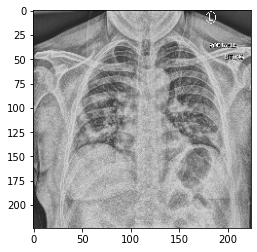

In [36]:
plt.figure()
plt.imshow(t0_IMG_val[4])

#### CLINICAL NORMALIZATION

In [37]:
X_cl_train = X_cl_train.drop(['to_patient_id','visit_concept_name', 'covid19_statuses'], axis='columns')
X_cl_val = X_cl_val.drop(['to_patient_id','visit_concept_name', 'covid19_statuses'], axis='columns')

scaler = MinMaxScaler()
X_cl_train = pd.DataFrame(scaler.fit_transform(X_cl_train), columns=X_cl_train.columns,index=X_cl_train.index)
X_cl_val = pd.DataFrame(scaler.transform(X_cl_val), columns=X_cl_val.columns,index=X_cl_val.index)


## USAGE OF PRETRAINED MODELS or TRAIN IF NEEDED

In [38]:
need_2_train_Clinical = False
need_2_train_CNN = True

In [39]:
# print(len(t0_IMG_val.shape))

In [40]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [41]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [42]:
# load Clinical model
if need_2_train_Clinical:
    model_clinical = clinical_fn.Create_MLP(X_cl_val.shape[1])


# load CNN model 4 images
if need_2_train_CNN:
    # model_CNN = cnn_fn.Create_CNN_with_DS(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    # model_CNN = cnn_fn.Create_CNN_with_DS(loss=focal_loss_custom(0.2, 2), optimizer=tf.keras.optimizers.Adam(
    #     learning_rate=0.0001,
    #     beta_1=0.9,
    #     beta_2=0.999,
    #     epsilon=1e-05,
    #     amsgrad=False,
    #     )
    # model_CNN = cnn_fn.Create_CNN_with_DS(loss=focal_loss_custom(0.2, 2),optimizer='adam')
    # model_CNN = cnn_fn.Create_CNN_with_DS(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m])
    # model_CNN = cnn_fn.Create_CNN_with_Lrog(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m])
    model_CNN = cnn_fn.Create_CNN_ASI(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m])

(None, 8720, 2)
(None, 8720, 2)
(None, 8720, 3)
(None, 3)


### TRAINING OF MODELS

In [43]:
print(t0_IMG_train.shape)

(1622, 224, 224, 3)


In [44]:
mildNumber = Y_im_train.sum()
severeNumber = Y_im_train.sum()
total = Y_im_train.sum().sum()
print("Labels for trainset:")
print(Y_cl_train.sum())
print("\nLabels for validationset:")
print(Y_cl_val.sum())

Labels for trainset:
MILD      811.0
SEVERE    212.0
dtype: float32

Labels for validationset:
MILD      211.0
SEVERE     45.0
dtype: float32


In [45]:
weight_for_mild = (1/(mildNumber)) * (total / 2.0)
weight_for_severe = (1/(severeNumber)) * (total / 2.0)

class_weights = {0: weight_for_mild, 1: weight_for_severe}

print(class_weights)

{0: 0.5, 1: 0.5}


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Generators
datagen = ImageDataGenerator(
        rotation_range=20, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        zoom_range=0.1, # zoom
        # horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.2] # brightness
        )

In [47]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
					SaveTrainModelsPath / Path('cnn'), 
   					monitor='val_f1_m', 
   					save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [48]:
# clinical:
if need_2_train_Clinical:
    history_clinical = clinical_fn.fit_mlp(X_cl_train,Y_cl_train,X_cl_val,Y_cl_val,model_clinical,SaveTrainModelsPath)
    
# cnn
if need_2_train_CNN:
    # history_CNN = cnn_fn.fit_cnn(t0_IMG_train,Y_im_train,t0_IMG_val,Y_im_val,model_CNN,SaveTrainModelsPath,ep=100,weights=class_weights,datagen=datagen)
    history_CNN = cnn_fn.fit_cnn(t0_IMG_train,Y_im_train,t0_IMG_val,Y_im_val,model_CNN,SaveTrainModelsPath,personalizeCheckpoint=True,checkpointList= callbacks_list,ep=300)
    # history_CNN = cnn_fn.fit_cnn(t0_IMG_train,Y_im_train[:10],t0_IMG_val,Y_im_val[:5],model_CNN,SaveTrainModelsPath,personalizeCheckpoint=True,checkpointList= callbacks_list,ep=1)

Epoch 1/300
51/51 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.5302 - f1_m: 0.5284

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


51/51 [==============================] - 12s 123ms/step - loss: 0.9630 - accuracy: 0.5302 - f1_m: 0.5284 - val_loss: 1.0554 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 2/300
51/51 [==============================] - 1s 20ms/step - loss: 0.6001 - accuracy: 0.5327 - f1_m: 0.5333 - val_loss: 0.8666 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 3/300
51/51 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.5530 - f1_m: 0.5538

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


51/51 [==============================] - 5s 102ms/step - loss: 0.4820 - accuracy: 0.5530 - f1_m: 0.5538 - val_loss: 0.8149 - val_accuracy: 0.1797 - val_f1_m: 0.1797
Epoch 4/300
51/51 [==============================] - 1s 20ms/step - loss: 0.4511 - accuracy: 0.5672 - f1_m: 0.5673 - val_loss: 0.7847 - val_accuracy: 0.1797 - val_f1_m: 0.1797
Epoch 5/300
51/51 [==============================] - 1s 18ms/step - loss: 0.4198 - accuracy: 0.5604 - f1_m: 0.5598 - val_loss: 0.7615 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 6/300
51/51 [==============================] - 1s 18ms/step - loss: 0.4047 - accuracy: 0.5672 - f1_m: 0.5654 - val_loss: 0.7465 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 7/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3843 - accuracy: 0.5623 - f1_m: 0.5624 - val_loss: 0.7357 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 8/300
48/51 [===========================>..] - ETA: 0s - loss: 0.3855 - accuracy: 0.5775 - f1_m: 0.5775

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


51/51 [==============================] - 5s 103ms/step - loss: 0.3850 - accuracy: 0.5752 - f1_m: 0.5742 - val_loss: 0.7278 - val_accuracy: 0.5508 - val_f1_m: 0.5508
Epoch 9/300
51/51 [==============================] - 1s 20ms/step - loss: 0.3694 - accuracy: 0.5715 - f1_m: 0.5719 - val_loss: 0.7211 - val_accuracy: 0.5039 - val_f1_m: 0.5039
Epoch 10/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3633 - accuracy: 0.5666 - f1_m: 0.5676 - val_loss: 0.7189 - val_accuracy: 0.2188 - val_f1_m: 0.2187
Epoch 11/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3639 - accuracy: 0.5697 - f1_m: 0.5692 - val_loss: 0.7197 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 12/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3533 - accuracy: 0.5789 - f1_m: 0.5795 - val_loss: 0.7191 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 13/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3513 - accuracy: 0.5863 - f1_m: 0.5855 - val_loss: 

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


51/51 [==============================] - 5s 103ms/step - loss: 0.3658 - accuracy: 0.5580 - f1_m: 0.5576 - val_loss: 0.5824 - val_accuracy: 0.8203 - val_f1_m: 0.8203
Epoch 15/300
51/51 [==============================] - 1s 21ms/step - loss: 0.3781 - accuracy: 0.5684 - f1_m: 0.5680 - val_loss: 0.7475 - val_accuracy: 0.1797 - val_f1_m: 0.1797
Epoch 16/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3678 - accuracy: 0.5654 - f1_m: 0.5636 - val_loss: 0.7813 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 17/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3638 - accuracy: 0.5629 - f1_m: 0.5633 - val_loss: 13.3082 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 18/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3651 - accuracy: 0.5703 - f1_m: 0.5704 - val_loss: 4.3196 - val_accuracy: 0.1758 - val_f1_m: 0.1758
Epoch 19/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3565 - accuracy: 0.5882 - f1_m: 0.5873 - val_loss

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\cnn\assets


51/51 [==============================] - 5s 104ms/step - loss: 0.3539 - accuracy: 0.5678 - f1_m: 0.5677 - val_loss: 2.6986 - val_accuracy: 0.8242 - val_f1_m: 0.8242
Epoch 24/300
51/51 [==============================] - 1s 22ms/step - loss: 0.3532 - accuracy: 0.5715 - f1_m: 0.5708 - val_loss: 2.2966 - val_accuracy: 0.8242 - val_f1_m: 0.8242
Epoch 25/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3674 - accuracy: 0.5777 - f1_m: 0.5783 - val_loss: 1.9689 - val_accuracy: 0.8242 - val_f1_m: 0.8242
Epoch 26/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3603 - accuracy: 0.5684 - f1_m: 0.5689 - val_loss: 2.8537 - val_accuracy: 0.8242 - val_f1_m: 0.8242
Epoch 27/300
51/51 [==============================] - 1s 18ms/step - loss: 0.3550 - accuracy: 0.5758 - f1_m: 0.5762 - val_loss: 2.7442 - val_accuracy: 0.8242 - val_f1_m: 0.8242
Epoch 28/300
51/51 [==============================] - 1s 19ms/step - loss: 0.3472 - accuracy: 0.5795 - f1_m: 0.5790 - val_loss:

KeyboardInterrupt: 

In [ ]:
model_CNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# clinical:
if need_2_train_Clinical:
    plt.clf()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        y=history_clinical.history['loss'],
                        name='Train segmentation loss'))
    fig.add_trace(go.Scatter(
                        y=history_clinical.history['val_loss'],
                        name='Valid segmentation loss'))
    fig.add_trace(go.Scatter(
                        y=history_clinical.history['accuracy'],
                        name='Train segmentation accuracy'))
    fig.add_trace(go.Scatter(
                        y=history_clinical.history['val_accuracy'],
                        name='Valid segmentation accuracy'))
    fig.update_layout(height=500, 
                      width=700,
                      title='Accuracy Clinical Data',
                      xaxis_title='Epoch',
                      yaxis_title='Accuracy')
    fig.show()

# cnn
if need_2_train_CNN:
    plt.clf()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['loss'],
                        name='Train loss'))
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['val_loss'],
                        name='Valid loss'))
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['accuracy'],
                        name='Train accuracy'))
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['val_accuracy'],
                        name='Valid accuracy'))
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['f1_m'],
                        name='Train F1 value'))
    fig.add_trace(go.Scatter(
                        y=history_CNN.history['val_f1_m'],
                        name='Valid F1 value'))
    fig.update_layout(height=500, 
                      width=700,
                      title='Accuracy CNN',
                      xaxis_title='Epoch',
                      yaxis_title='Accuracy')
    fig.show()

<Figure size 432x288 with 0 Axes>

### Load trained Models

In [ ]:
def binary_focal_loss(y_true, y_pred):
    fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2, gamma=2)
    y_true_K = K.ones_like(y_true)
    focal_loss = fl(y_true, y_pred)
    return focal_loss

In [ ]:
model_clinical = clinical_fn.load_best_mlp(SaveTrainModelsPath)
# model_CNN = cnn_fn.load_best_cnn(SaveTrainModelsPath)
# model_CNN = cnn_fn.load_best_cnn(SaveTrainModelsPath, customObjects={'binary_focal_loss': focal_loss_custom(0.2, 2)})

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

## METRICS SKLEARN

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score

In [ ]:
print("CLINICAL\n")

cm=confusion_matrix(np.argmax(Y_cl_val.to_numpy(), axis=1),np.argmax(model_clinical.predict(X_cl_val), axis=1))
print("\n confusion matrix" + str(cm)+"\n")

acc=accuracy_score(np.argmax(Y_cl_val.to_numpy(), axis=1),np.argmax(model_clinical.predict(X_cl_val), axis=1))
print("\n accuracy" + str(acc)+"\n")

recall=recall_score(np.argmax(Y_cl_val.to_numpy(), axis=1),np.argmax(model_clinical.predict(X_cl_val), axis=1))
print("\n recall" + str(recall)+"\n")

precision=precision_score(np.argmax(Y_cl_val.to_numpy(), axis=1),np.argmax(model_clinical.predict(X_cl_val), axis=1))
print("\n precision" + str(precision)+"\n")


CLINICAL

8/8 [==============================] - 0s 2ms/step

 confusion matrix[[206   5]
 [ 11  34]]

8/8 [==============================] - 0s 997us/step

 accuracy0.9375

8/8 [==============================] - 0s 2ms/step

 recall0.7555555555555555

8/8 [==============================] - 0s 1ms/step

 precision0.8717948717948718



In [ ]:
print("CNN\n")

cm=confusion_matrix(np.argmax(Y_im_val.to_numpy(), axis=1),np.argmax(model_CNN.predict(t0_IMG_val), axis=1))
print("\n confusion matrix" + str(cm)+"\n")

acc=accuracy_score(np.argmax(Y_im_val.to_numpy(), axis=1),np.argmax(model_CNN.predict(t0_IMG_val), axis=1))
print("\n accuracy" + str(acc)+"\n")

recall=recall_score(np.argmax(Y_im_val.to_numpy(), axis=1),np.argmax(model_CNN.predict(t0_IMG_val), axis=1))
print("\n recall" + str(recall)+"\n")

precision=precision_score(np.argmax(Y_im_val.to_numpy(), axis=1),np.argmax(model_CNN.predict(t0_IMG_val), axis=1))
print("\n precision" + str(precision)+"\n")


CNN

8/8 [==============================] - 2s 25ms/step

 confusion matrix[[211   0]
 [ 45   0]]

8/8 [==============================] - 0s 23ms/step

 accuracy0.82421875

8/8 [==============================] - 0s 23ms/step

 recall0.0

8/8 [==============================] - 0s 25ms/step

 precision0.0



c:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



## CLINICAL DATA CLASSIFICATION

In [ ]:
p_Clinical = model_clinical.prediction(X_cl_val)

AttributeError: 'Sequential' object has no attribute 'prediction'

## CNN Classification

In [ ]:
p_RX = model_CNN.prediction(t0_IMG_val)

## COMBINATION OF THE p and Decision

In [ ]:
def decisionFusion():
    probOut = 0

    return probOut

In [ ]:
p_Out = decisionFusion(p_Clinical,p_RX)